In [1]:
%matplotlib inline

In [206]:
import numpy as np
import pytesseract
import cv2
from timeit import default_timer

In [9]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [3]:
from imutils.object_detection import non_max_suppression

In [159]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [5]:
def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
 
	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
 
		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < args["min_confidence"]:
				continue
 
			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
 
			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
 
			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
 
			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
 
			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
 
	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [28]:
image = cv2.imread("../assets/images/word.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
orig = image.copy()

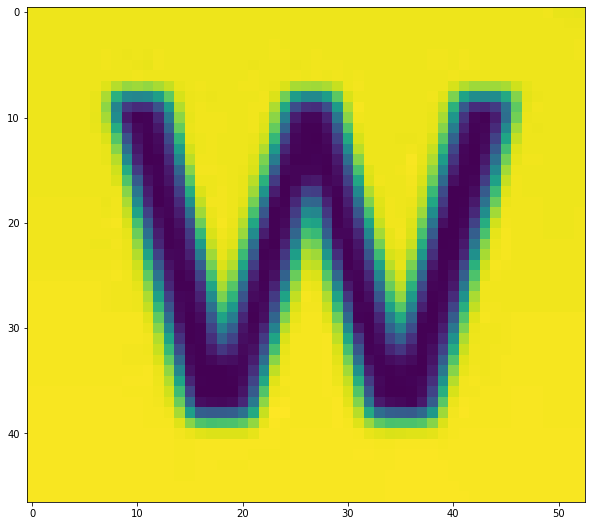

In [29]:
plt.imshow(image)

In [37]:
pytesseract.image_to_string(image, lang="eng", config="--psm 10")

'W'

In [80]:
bounding_boxes = cv2.imread("../assets/images/bounding_boxes.png", cv2.IMREAD_UNCHANGED)
print(bounding_boxes.shape)
bounding_boxes = cv2.cvtColor(bounding_boxes, cv2.COLOR_BGRA2RGBA)

(417, 437, 4)


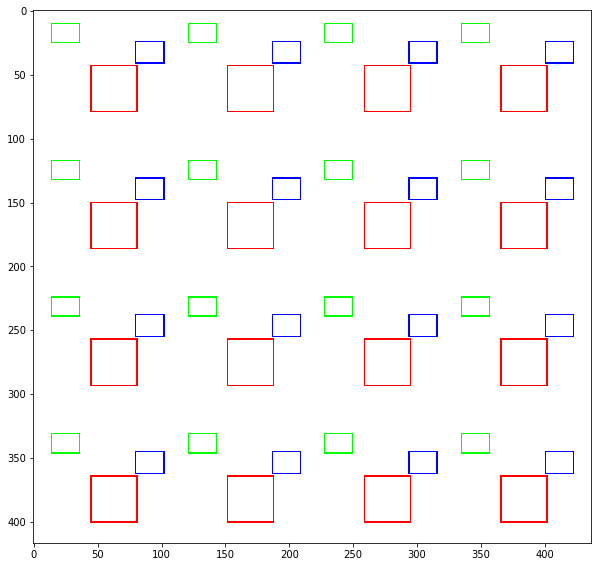

In [81]:
plt.imshow(bounding_boxes)

In [82]:
# height, width, channels
bounding_boxes.shape

(417, 437, 4)

In [88]:
bounding_boxes[43,50,:]

array([255,   0,   0, 255], dtype=uint8)

In [121]:
# image = 4 channel
# colour = 4 channel
# assume boxes will be the same shape
def get_bounding_boxes(image, box_colour):
    height, width = image.shape[:2]
    bounding_boxes = []
    
    last_box_height = None
    box_height = None
    box_width = None
    
    y = 0
    x = 0
    while y < height:
        x = 0
        while x < width:
            colour = image[y,x,:]
            if not (colour == box_colour).all():
                x += 1
                continue
            # if box colour, then find top and left edges
            x_start = x
            y_start = y
            
            # if box shape known, just predict
            if box_height is not None and box_width is not None:
                x_end = x_start+box_width
                y_end = y_start+box_height
                bounding_box = (x_start, y_start, x_end-1, y_end-1)
                bounding_boxes.append(bounding_box)
                last_box_height = box_height
                x = x_end+1
                continue
            
            # if finding box shape for first time
            x_end = x
            y_end = y
            _x = x_start+1
            _y = y_start+1
            # check top edge
            while _x < width:
                colour = image[y,_x,:]
                if not (colour == box_colour).all():
                    x_end = _x
                    break
                _x += 1
            # check left edge
            while _y < height:
                colour = image[_y,x,:]
                if not (colour == box_colour).all():
                    y_end = _y
                    break
                _y += 1
            # check if box or not
            box_width = x_end-x_start
            box_height = y_end-y_start
            if box_width > 1 and box_height > 1:
                bounding_box = (x_start, y_start, x_end-1, y_end-1)
                bounding_boxes.append(bounding_box)
                x = x_end
                last_box_height = box_height
            # increment normally
            x += 1
        
        if last_box_height is not None:
            y += last_box_height + 1
            last_box_height = None
        else:
            y += 1
                
    return bounding_boxes

In [126]:
boxes = get_bounding_boxes(bounding_boxes, (0, 0, 255, 255))

In [127]:
box = boxes[0]

In [128]:
box

(80, 24, 102, 41)

In [198]:
sample = cv2.imread("../assets/samples/sample_0.png")
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGBA)

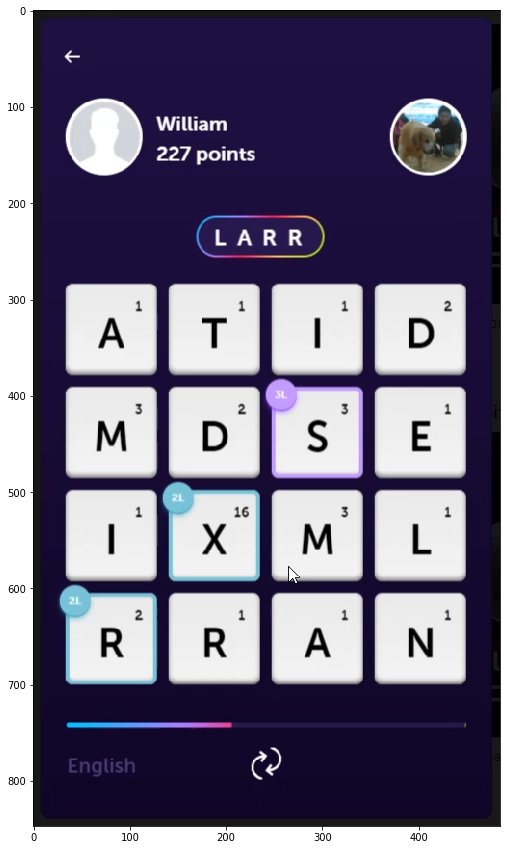

In [199]:
plt.imshow(sample)

In [142]:
from PIL import Image

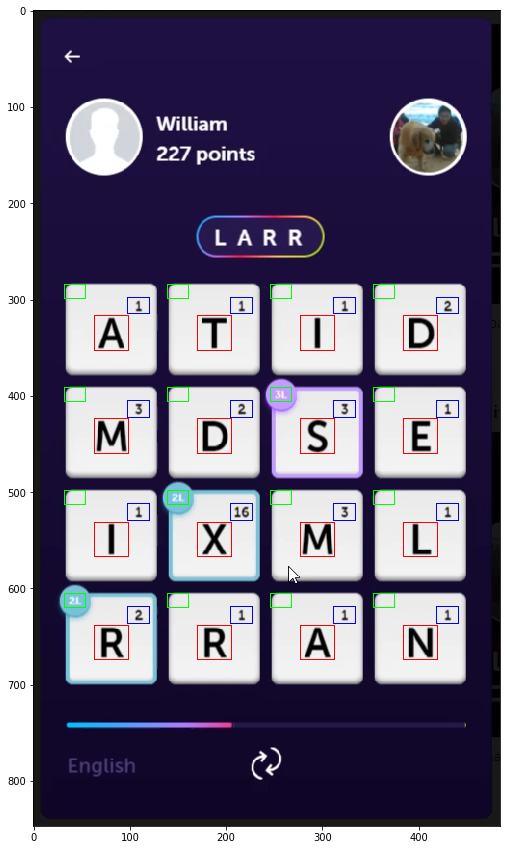

In [200]:
pil_sample = Image.fromarray(sample)
pil_boxes = Image.fromarray(bounding_boxes)
offset = (18, 274)
pil_sample.paste(pil_boxes, offset, pil_boxes)
plt.imshow(np.array(pil_sample))

In [292]:
boxes = get_bounding_boxes(bounding_boxes, (255, 0, 0, 255))

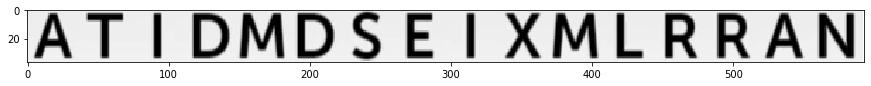

In [315]:
left, top, right, bottom = boxes[0]
width = right-left+1
height = bottom-top

canvas = np.full((height+1, 16*width + 1, 3), 255)
#plt.imshow(canvas)

for i, box in enumerate(boxes):
    x_start, y_start, x_end, y_end = box
    x_offset, y_offset = offset
    start = default_timer()
    cropped_sample = sample[y_start+y_offset:y_end+y_offset+1, x_start+x_offset:x_end+x_offset+1,:3]
    canvas[:,i*width:(i+1)*width,:3] = cropped_sample
    end = default_timer()
    print(f"{(end-start)*1000}ms/crop", end="\r")
plt.imshow(canvas)

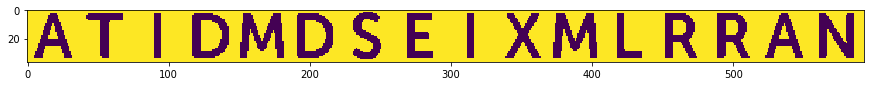

In [316]:
canvas = np.array(canvas, dtype=np.uint8)
image = cv2.cvtColor(canvas, cv2.COLOR_RGB2GRAY)
_, image = cv2.threshold(image, 140, 255, cv2.THRESH_BINARY)
plt.imshow(image)

In [318]:
whitelist = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
start = default_timer()
label = pytesseract.image_to_string(image, lang="eng", config=f"--psm 7 -c tessedit_char_whitelist={whitelist}")
end = default_timer()
print(label, end-start)

ATIDMDSEIXMLRRAN 0.29137940000146045
